In [1]:
import xarray as xr
import numpy as np

#import gribscan
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import intake
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
def ifs_to_latlon(ds):
    '''
    Uses the latitude-longitude information encoded in the regular grid IFS output to reconstructed the regular grid
    '''
    return ds.rename({'value':'latlon'}).set_index(latlon=("lat","lon")).unstack("latlon")

# -- regional average
def wgt_areaave(indat, latS, latN, lonW, lonE):
  lat=indat.lat
  lon=indat.lon

  if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
     anm=indat.assign_coords(lon=( (lon + 180) % 360 - 180) )
     longitude=( (lon + 180) % 360 - 180)
  else:
     anm=indat

  iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
  iplon = lon.where( (lon >= lonW ) & (lon <= lonE), drop=True)

#  print(iplat)
#  print(iplon)
  wgt = np.cos(np.deg2rad(lat))
  odat=anm.sel(lat=iplat,lon=iplon).weighted(wgt).mean(("lon", "lat"), skipna=True)
  return(odat)

In [3]:
ds = xr.open_zarr("reference::/work/bm1344/a270228/phase1_hist/gribscan_1m_REGULARLL/jsons.1950-2014/pl.dir/atm3d_avg.json", consolidated=False)
ds

<xarray.Dataset>
Dimensions:  (value: 1038240, level: 19, time: 780)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * level    (level) int64 1 5 10 20 30 50 70 ... 400 500 600 700 850 925 1000
    lon      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1950-01-15T12:00:00 ... 2014-12-15T12:00:00
Dimensions without coordinates: value
Data variables:
    mq       (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    mr       (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    mt       (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    mu       (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    mv       (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    mw       (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    mz       (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [4]:
t = ds['mu']
t
temp = ifs_to_latlon(t)
temp

<xarray.DataArray 'mu' (time: 780, level: 19, lat: 721, lon: 1440)>
dask.array<reshape, shape=(780, 19, 721, 1440), dtype=float64, chunksize=(1, 1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * level    (level) int64 1 5 10 20 30 50 70 ... 400 500 600 700 850 925 1000
  * time     (time) datetime64[ns] 1950-01-15T12:00:00 ... 2014-12-15T12:00:00
Attributes: (12/30)
    paramId:                             235131
    dataType:                            fc
    numberOfPoints:                      1038240
    typeOfLevel:                         isobaricInhPa
    stepUnits:                           1
    stepType:                            avg
    ...                                  ...
    latitudeOfFirstGridPointInDegrees:   90.0
    longitudeOfFirstGridPointInDegrees:  0.0
    iDirectionIncrementInDegrees:        0.25
    jDirectionIncrementInDegrees:        0.25
    iScansNegatively:                    0
    jScansPositively:                    0

In [5]:
#t_clim= temp.sel(time=slice('1979', '2008')).mean('time')
t_clim_zonal_mean = temp.sel(time=slice('1979', '2008'),level=slice(5,1000)).mean(dim=['time', 'lon'])
# Filter data to only include pressure levels from 100 hPa to 5 hPa
#filtered_t_clim.plot()

In [6]:
dset = xr.open_dataset('/work/bm1344/a270228/ERA5/data_uwind_ERA5_1979-2008_ym.nc')

t_era5= dset['var131']
t_era5

t_era5 = t_era5.assign_coords(
    plev=t_era5.plev / 100
).rename({'plev': 'level'})  # Rename 'plev' to 'level'


In [7]:
t_era_clim_zonal_mean = t_era5.sel(time=slice('1979', '2008'),level=slice(5,1000)).mean(dim=['time', 'lon'])
t_era_clim_zonal_mean

<xarray.DataArray 'var131' (level: 18, lat: 721)>
array([[-4.55220543e-05,  2.20849842e-01,  4.26937044e-01, ...,
         6.86629236e-01,  3.67655039e-01, -4.55220543e-05],
       [ 5.63303620e-05,  2.01313362e-01,  3.96767765e-01, ...,
         6.29269540e-01,  3.31278294e-01,  5.63303620e-05],
       [ 3.87509681e-05,  1.79690048e-01,  3.55445445e-01, ...,
         5.50170183e-01,  2.86309391e-01,  3.87509681e-05],
       ...,
       [ 8.59578431e-05, -7.47785764e-03,  4.78173047e-02, ...,
        -2.38100737e-02,  6.23778291e-02,  8.59578431e-05],
       [-3.66210952e-05, -2.65720952e-02,  3.17275934e-02, ...,
        -1.66806374e-02,  5.38279153e-02, -3.66210952e-05],
       [ 4.03404229e-05,  1.23832317e-03, -1.51218735e-02, ...,
        -4.60499376e-02,  8.86193067e-02,  4.03404229e-05]], dtype=float32)
Coordinates:
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * level    (level) float64 5.0 10.0 20.0 30.0 50.0 ... 700.0 850.0 925.0 1e+03

In [8]:
diff_t_clim_zonal_mean = (t_clim_zonal_mean - t_era_clim_zonal_mean)
diff_t_clim_zonal_mean

<xarray.DataArray (level: 18, lat: 721)>
dask.array<sub, shape=(18, 721), dtype=float64, chunksize=(1, 721), chunktype=numpy.ndarray>
Coordinates:
  * level    (level) int64 5 10 20 30 50 70 100 ... 400 500 600 700 850 925 1000
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0

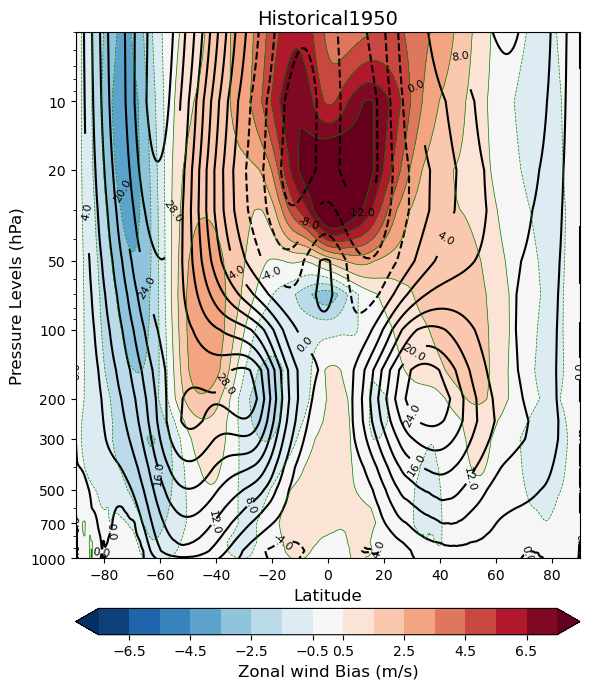

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the plot
fig, ax = plt.subplots(figsize=(6, 7))

# Plot observations (contours) with light green color
t_era_zonal_contour = ax.contour(
    t_era_clim_zonal_mean.lat,
    t_era_clim_zonal_mean.level,
    t_era_clim_zonal_mean,
    levels=12,
    colors='black',
    linewidths=1.5
)

# Add labels to the contour lines
ax.clabel(t_era_zonal_contour, inline=True, colors='black', inline_spacing=0.05, fontsize=8, fmt='%1.1f')
#ax.clabel(t_era_zonal_contour, inline=True, colors='black', fontsize=8, fmt='%1.1f', manual=True)


# Example values for `levels`, can be modified as needed
num_levels = 16  # Number of color levels
levels = np.linspace(-7.5, 7.5, num_levels)

# Plot model bias (shading) on top of observations
im = ax.contourf(
    diff_t_clim_zonal_mean.lat,
    diff_t_clim_zonal_mean.level,
    diff_t_clim_zonal_mean,
    levels=levels,
    cmap='RdBu_r',
    extend='both'
)

# Add contour lines for the shading part
contour_lines = ax.contour(
    diff_t_clim_zonal_mean.lat,
    diff_t_clim_zonal_mean.level,
    diff_t_clim_zonal_mean,
    levels=levels,
    colors='green',
    linestyles=['dashed' if l < 0 else 'solid' for l in levels],
    linewidths=0.5  # Set thinner line width
)

# Set the y-axis to a logarithmic scale
ax.set_yscale('log')
ax.invert_yaxis()  # Invert the pressure axis for proper orientation

# Customize y-axis ticks
pressure_ticks = np.array([1000, 700, 500, 300, 200, 100, 50, 20, 10])
ax.set_yticks(pressure_ticks)
ax.set_yticklabels(pressure_ticks)

# Add titles and labels
ax.set_title('Historical1950', fontsize=14)
ax.set_xlabel('Latitude', fontsize=12)
ax.set_ylabel('Pressure Levels (hPa)', fontsize=12)

# Add gridlines
#ax.grid(which='both', linestyle='--', alpha=0.5)

# Create a divider for existing axes instance
divider = make_axes_locatable(ax)

# Add an axes below the main axes
cax = divider.append_axes("bottom", size="5%", pad=0.5)

# Create colorbar in the appended axes
cbar = plt.colorbar(im, cax=cax, orientation='horizontal',ticks=[-6.5, -4.5, -2.5, -.5, .5, 2.5, 4.5, 6.5])
cbar.set_label("Zonal wind Bias (m/s)", fontsize=12)

plt.tight_layout()

plt.savefig("uwind_zonal_mean_climatology_with_bias.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
